In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
import re
import string
import os
import pickle

In [3]:
cd ..

/data/nasif12/home_if12/chengju/project/news


In [9]:
fkn = pd.read_pickle("./data/fkn_back.gzip")

In [10]:
title = fkn["title"].apply(lambda x: " ".join(x))
texts = fkn["text"].apply(lambda x: " ".join(x))
labels = fkn['label']

## word to index

https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

In [12]:
# To turn,  maximum number of top words to consider (sorted by freq)
MAX_NB_WORDS = 50000

In [13]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [14]:
pickle.dump(tokenizer, open('./data/tokenizer.pkl', 'wb'))

In [15]:
artical_len = [len(sq) for sq in sequences]
[i for i, j in enumerate(artical_len) if j == max(artical_len)] 

[4733]

(array([  5.99300000e+03,   2.79000000e+02,   4.30000000e+01,
          1.50000000e+01,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00]),
 array([     0.,   1164.,   2328.,   3492.,   4656.,   5820.,   6984.,
          8148.,   9312.,  10476.,  11640.]),
 <a list of 10 Patch objects>)

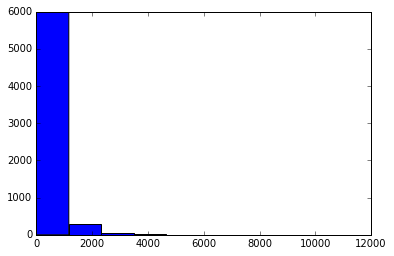

In [16]:
plt.hist(artical_len)

In [17]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 78439 unique tokens.


In [18]:
# maximum sequence length of an artical, shorter ones are padded with 0 at the beginning
# longer ones take the last MAX_SEQUENCE_LENGTH ones
MAX_SEQUENCE_LENGTH = 2000

In [19]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [20]:
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (6335, 2000)
Shape of label tensor: (6335, 2)


In [21]:
VALIDATION_SPLIT = 0.2

In [22]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

In [23]:
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [24]:
x_train.shape

(5068, 2000)

## Embedding

In [25]:
embeddings_index = {}
f = open('./data/GloVe/glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [26]:
EMBEDDING_DIM = 50

In [27]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [28]:
embedding_matrix.shape

(78440, 50)

In [29]:
#pickle.dump(embedding_matrix, open('./data/embedding_matrix.pkl', 'wb'))

In [30]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

## Train networks

In [31]:
## required keras modules
from keras.models import Model, load_model
import keras.layers as kl
import keras.optimizers as ko
from keras import backend as k 
from keras import regularizers
from keras.layers.advanced_activations import PReLU
from keras.utils import np_utils
import keras.callbacks as kc

In [32]:
sequence_input = kl.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = kl.Conv1D(64, 3, activation='relu',
             kernel_regularizer=regularizers.l2(0.005))(embedded_sequences)
x = kl.MaxPooling1D(pool_size=2)(x)  # global max pooling
x = kl.BatchNormalization()(x)
x = kl.Bidirectional(kl.LSTM(50, recurrent_regularizer=regularizers.l2(0.006)))(x)
#x = kl.Dropout(0.2)(x)
preds = kl.Dense(2, activation='sigmoid')(x)
model = Model(sequence_input, preds)

In [49]:
model.compile(loss='binary_crossentropy', 
              optimizer=ko.RMSprop(lr=0.0001), 
              metrics=['acc'])

In [50]:
model.layers

In [51]:
model.fit(x_train, y_train, 
          #validation_split=.2,
          validation_data=(x_val, y_val),
          epochs=200, 
          batch_size=128,
          callbacks=[kc.EarlyStopping(patience=2)])

Train on 5068 samples, validate on 1267 samples
Epoch 1/200
5068/5068 [==============================] - 186s - loss: 1.2190 - acc: 0.6545 - val_loss: 1.2333 - val_acc: 0.6318
Epoch 2/200
5068/5068 [==============================] - 182s - loss: 1.1008 - acc: 0.7479 - val_loss: 1.1832 - val_acc: 0.6646
Epoch 3/200
5068/5068 [==============================] - 182s - loss: 1.0059 - acc: 0.7826 - val_loss: 1.1369 - val_acc: 0.6803
Epoch 4/200
2176/5068 [===========>..................] - ETA: 101s - loss: 0.9438 - acc: 0.8086

KeyboardInterrupt: 

In [161]:
# model.save("./data/models/LSTM")
#model.save("./data/models/CNN_LSTM2")

In [33]:
from keras.models import load_model
model = load_model("./data/models/CNN_LSTM2")

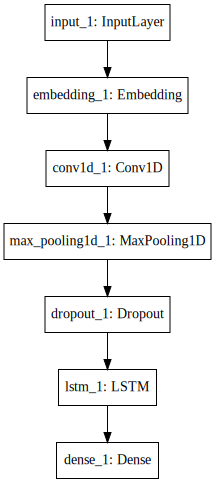

In [5]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [34]:
predict_val = model.predict(x_val)

In [36]:
from sklearn import metrics

In [59]:
metrics.roc_auc_score(y_val, predict_val)

0.94165668812054082

In [55]:
auc_val = metrics.auc(true_prob, y_prob,reorder=True)

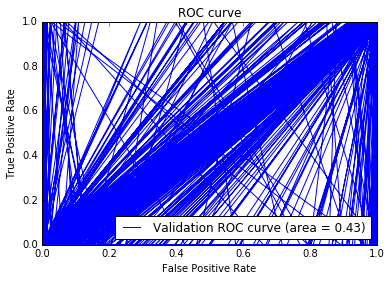

In [57]:
     
#plt.plot(fpr_train, tpr_train,
#        label='Training ROC curve (area = %0.2f)' % auc_train)
plt.plot(true_prob, y_prob, 
        label='Validation ROC curve (area = %0.2f)' % auc_val)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC curve")
plt.legend(loc='lower right')
plt.show()

In [147]:
history = model.history.history

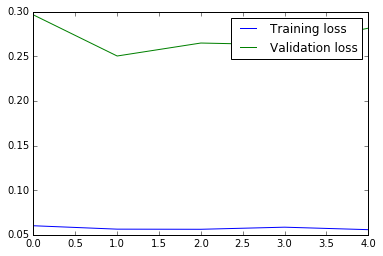

In [148]:
plt.plot(history['loss'], label="Training loss")
plt.plot(history['val_loss'], label="Validation loss")
plt.legend(loc="upper right")

In [118]:
from keras.models import load_model
model = load_model("./data/models/CNN_LSTM2")

from keras.utils import plot_model
plot_model(model, to_file="./data/model.png")